In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

ValueError: ignored

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.optim as optim 
import numpy as np
import os
import math
import random
from tqdm import tqdm

In [3]:
batch_size = 128
num_workers = 2
train_percent = 0.9
noise_percent = 0.1

In [4]:
def gen_randint(low, high, discard):
	result_list = list(range(low, high))
	result_list.remove(discard)
	np.random.shuffle(result_list)
	return result_list.pop()
 
def label_noise(dataset, percent):
  length = len(dataset)
  index = random.sample(range(length), int(length*percent))
  for idx in index:
    dataset[idx][1] = gen_randint(0,10,dataset[idx][1])


In [ ]:
np.random.uniform(0,1, len(noise_label))

array([0.74376075, 0.9398747 , 0.61305026, ..., 0.09070416, 0.16853667,
       0.1954518 ])

In [7]:
trainset = torchvision.datasets.CIFAR10(root='/content/gdrive/MyDrive/6699/data', train=True, download=True, transform=transform)


Files already downloaded and verified


In [5]:
# 数据转换
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 加载训练数据和测试数据
train_size = 1000
test_size = 600
trainset = torchvision.datasets.CIFAR10(root='/content/gdrive/MyDrive/6699/data', train=True, download=True, transform=transform)
trainset, _ = random_split(trainset, [train_size, len(trainset)-train_size])


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='/content/gdrive/MyDrive/6699/data', train=False, download=True, transform=transform)
testset, _ = random_split(testset, [test_size, len(testset)-test_size])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/6699/data/cifar-10-python.tar.gz to /content/gdrive/MyDrive/6699/data
Files already downloaded and verified


In [31]:
def CNN(width):
  layers = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(width),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=1, stride=2),
      nn.Conv2d(in_channels=width, out_channels=2*width, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(2*width),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=2*width, out_channels=4*width, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(4*width),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.Linear(in_features=64*width, out_features=10),
      # nn.ReLU(),
      # nn.Linear(in_features=2*width, out_features=width),
      # nn.ReLU(),
      # nn.Linear(in_features=width, out_features=10),
    )

  return layers

In [34]:
model = CNN(1)
x = torch.rand([5,3,32,32])
for name, module in model.named_children():
  x = module(x)
  # print(name)
  print("({}) : {}".format(name,x.shape))

(0) : torch.Size([5, 1, 32, 32])
(1) : torch.Size([5, 1, 32, 32])
(2) : torch.Size([5, 1, 32, 32])
(3) : torch.Size([5, 1, 16, 16])
(4) : torch.Size([5, 2, 16, 16])
(5) : torch.Size([5, 2, 16, 16])
(6) : torch.Size([5, 2, 16, 16])
(7) : torch.Size([5, 2, 8, 8])
(8) : torch.Size([5, 4, 8, 8])
(9) : torch.Size([5, 4, 8, 8])
(10) : torch.Size([5, 4, 8, 8])
(11) : torch.Size([5, 4, 4, 4])
(12) : torch.Size([5, 64])
(13) : torch.Size([5, 10])


In [45]:
class Classifier():

    def __init__(self, name, model, use_cuda=False):
        
        '''
        @name: Experiment name. Will define stored results etc. 
        @model: Either a GradBasicNet() or a GradAlexNet()
        @dataloaders: Dictionary with keys train, val and test and corresponding dataloaders
        @class_names: list of classes, where the idx of class name corresponds to the label used for it in the data
        @use_cuda: whether or not to use cuda
        '''
        
        self.name = name
        if use_cuda and not torch.cuda.is_available():
            raise Exception("Asked for CUDA but GPU not found")
            
        self.use_cuda = use_cuda
        
        self.model = model.to('cuda' if use_cuda else 'cpu')

        #TODO
        self.criterion = nn.CrossEntropyLoss() #use cross entropy loss
        self.optim = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #use SGD with suggest hyperparams; you must select all the model params
        # self.optim = optim.SGD(model.parameters(), lr=0.1)

        # self.dataloaders = dataloaders
        # self.class_names = class_names
        # self.activations_path = os.path.join('activations', self.name)
        # self.kernel_path = os.path.join('kernel_viz', self.name)

        save_path = os.path.join(os.getcwd(), 'models', self.name)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            
        self.save_path = save_path

    def train(self, epochs, save=True):
        '''
        @epochs: number of epochs to train
        @save: whether or not to save the checkpoints
        '''

        # best_val_accuracy = - math.inf

        for epoch in tqdm(range(epochs)):

            self.model.train()

            batches_in_pass = len(trainloader)
            
            #You may comment these two lines if you do not wish to use them
            loss_total = 0.0 # Record the total loss within a few steps
            epoch_loss = 0.0 # Record the total loss for each epoch
            
            # TODO Iterate over the training dataloader (see how it is done for validation below) and make sure
            # to call the optim.zero_grad(), loss.backward() and optim.step()
            for idx, data in enumerate(trainloader):
                inputs, labels = data
                # print('===================')
                # print(labels[0])
                labels_temp = labels.clone()
                labels_temp[0] = gen_randint(0,10,labels_temp[0])
                labels_temp.float().requires_grad_()
                # print(labels[0])
                # print(labels_temp[0])
                inputs = inputs.to('cuda' if self.use_cuda else 'cpu')
                labels_temp = labels_temp.to('cuda' if self.use_cuda else 'cpu')

                outputs = self.model(inputs)

                loss = self.criterion(outputs, labels_temp)
                loss_total += loss.item()
                optimizer = self.optim
                # print(optimizer.param_groups[0]['lr'])
                
                # optimizer.param_groups[0]['lr'] = 10/math.sqrt(idx+1) 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if idx%(10000/batch_size)==0 and idx!=0:
                  # print(f'epoch: {epoch+1}, step: {idx}, average_loss: {loss_total/2000:.4f}')
                  
                  epoch_loss += loss_total
                  loss_total = 0.0

            '''Give validation'''
            epoch_loss /= batches_in_pass

            # print(f'Train Epoch Loss (Avg): {epoch_loss}')
            # print(f'Validation Epoch Accuracy:{epoch_accuracy}')
            
        if save:
            #  Make sure that your saving pipeline is working well. 
            # Is os library working on your file system? 
            # Is your model being saved and reloaded fine? 
            # When you do the kernel viz, activation maps, 
            # and GradCAM you must be using the model you have saved before.
            
            # torch.save(self.model.state_dict(), os.path.join(self.save_path, f'epoch_{epoch}.pt'))
            
            

            torch.save(self.model.state_dict(), os.path.join(self.save_path, 'best.pt'))
                  

        # print('Done training!')                       

    def evaluate_train(self):
        
        try:
            assert os.path.exists(os.path.join(self.save_path, 'best.pt'))
            
        except:
            print('It appears you are testing the model without training. Please train first')
            return
        
        self.model.load_state_dict(torch.load(os.path.join(self.save_path, 'best.pt')))
        self.model.eval()

        #total = len(self.dataloaders['test'])
        
        correct = 0.0
        total = 0.0
        for idx, data in enumerate(trainloader):
            
                inputs, labels = data
                labels_temp = labels.clone()
                labels_temp[0] = gen_randint(0,10,labels_temp[0])
                labels_temp.float().requires_grad_()
                inputs = inputs.to('cuda' if self.use_cuda else 'cpu')
                labels_temp = labels_temp.to('cuda' if self.use_cuda else 'cpu')
                
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                
                total += labels_temp.shape[0]
                correct += (predicted == labels_temp).sum().item()
                
        # print(f'Training Accuracy: {100 * correct/total}%')
        return 1 - correct/total

    def evaluate_test(self):
        
        try:
            assert os.path.exists(os.path.join(self.save_path, 'best.pt'))
            
        except:
            print('It appears you are testing the model without training. Please train first')
            return
        
        self.model.load_state_dict(torch.load(os.path.join(self.save_path, 'best.pt')))
        self.model.eval()

        #total = len(self.dataloaders['test'])
        
        correct = 0.0
        total = 0.0
        for idx, data in enumerate(testloader):
            
                inputs, labels = data
                labels_temp = labels.clone()
                labels_temp[0] = gen_randint(0,10,labels_temp[0])
                labels_temp.float().requires_grad_()
                inputs = inputs.to('cuda' if self.use_cuda else 'cpu')
                labels_temp = labels_temp.to('cuda' if self.use_cuda else 'cpu')
                
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                
                total += labels_temp.shape[0]
                correct += (predicted == labels_temp).sum().item()
                
        # print(f'Testing Accuracy: {100 * correct/total}%')
        return 1 - correct/total

    

In [ ]:
# function ClickConnect(){
#     console.log("Clicked on connect button"); 
#     document.querySelector("colab-connect-button").click()
# }
# setInterval(ClickConnect,60000)

In [46]:
train_result = {}
test_result = {}
for width in range(5, 20):
  experiment_name = f'CNN_{width}_20%noise'  #Provide name to model experiment
  model_name = f'CNN_{width}_20%noise' 

  model = CNN(width)

  classifier = Classifier(experiment_name, model, use_cuda=True)
  # classifier.train(epochs=5) # For your reference
  classifier.train(epochs=1000)
  train_error = classifier.evaluate_train()
  test_error = classifier.evaluate_test()
  print(f'width = {width}, train_error = {train_error}, test_error = {test_error}')
  train_result[width] = train_error
  test_result[width] = test_error

100%|██████████| 1000/1000 [03:52<00:00,  4.30it/s]


width = 5, train_error = 0.008000000000000007, test_error = 0.655


100%|██████████| 1000/1000 [04:03<00:00,  4.10it/s]


width = 6, train_error = 0.008000000000000007, test_error = 0.6433333333333333


100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]


width = 7, train_error = 0.008000000000000007, test_error = 0.5883333333333334


100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]


width = 8, train_error = 0.008000000000000007, test_error = 0.615


100%|██████████| 1000/1000 [04:38<00:00,  3.59it/s]


width = 9, train_error = 0.008000000000000007, test_error = 0.6416666666666666


100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


width = 10, train_error = 0.008000000000000007, test_error = 0.5866666666666667


100%|██████████| 1000/1000 [05:03<00:00,  3.29it/s]


width = 11, train_error = 0.008000000000000007, test_error = 0.5833333333333333


100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]


width = 12, train_error = 0.008000000000000007, test_error = 0.5966666666666667


100%|██████████| 1000/1000 [05:28<00:00,  3.05it/s]


width = 13, train_error = 0.008000000000000007, test_error = 0.5766666666666667


100%|██████████| 1000/1000 [05:46<00:00,  2.89it/s]


width = 14, train_error = 0.008000000000000007, test_error = 0.5766666666666667


100%|██████████| 1000/1000 [05:55<00:00,  2.81it/s]


width = 15, train_error = 0.008000000000000007, test_error = 0.5816666666666667


100%|██████████| 1000/1000 [06:11<00:00,  2.69it/s]


width = 16, train_error = 0.008000000000000007, test_error = 0.5866666666666667


100%|██████████| 1000/1000 [06:25<00:00,  2.59it/s]


width = 17, train_error = 0.008000000000000007, test_error = 0.5800000000000001


100%|██████████| 1000/1000 [06:43<00:00,  2.48it/s]


width = 18, train_error = 0.008000000000000007, test_error = 0.5333333333333333


100%|██████████| 1000/1000 [06:57<00:00,  2.40it/s]


width = 19, train_error = 0.008000000000000007, test_error = 0.5633333333333334


In [47]:
import matplotlib.pyplot as plt


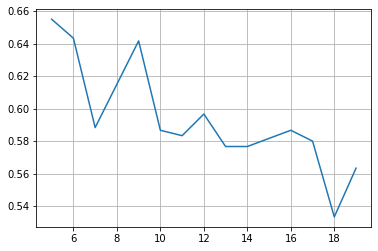

In [60]:
plt.plot(list(range(5, 20)), list(test_result.values()))
# plt.plot(list(range(5, 20)), list(train_result.values()))
# plt.legend()
plt.grid()
plt.show()

In [ ]:
train_result = {}
test_result = {}
for width in range(1, 65):
  experiment_name = f'CNN_{width}'  #Provide name to model experiment
  model_name = f'CNN_{width}' 

  model = CNN(width)

  classifier = Classifier(experiment_name, model, use_cuda=True)
  # classifier.train(epochs=5) # For your reference
  classifier.train(epochs=10)
  train_error = classifier.evaluate_train()
  test_error = classifier.evaluate_test()
  print(f'width = {width}, train_error = {train_error}, test_error = {test_error}')
  train_result[width] = train_error
  test_result[width] = test_error

Done training!
width = 1, train_error = 0.6499111111111111, test_error = 0.6482
Done training!
width = 2, train_error = 0.5190888888888889, test_error = 0.5301
Done training!
width = 3, train_error = 0.45442222222222217, test_error = 0.47230000000000005
Done training!
width = 4, train_error = 0.39002222222222227, test_error = 0.41390000000000005
Done training!
width = 5, train_error = 0.3472222222222222, test_error = 0.39039999999999997
Done training!
width = 6, train_error = 0.32582222222222224, test_error = 0.36819999999999997
Done training!
width = 7, train_error = 0.29259999999999997, test_error = 0.34919999999999995
Done training!
width = 8, train_error = 0.3032444444444444, test_error = 0.3526
Done training!
width = 9, train_error = 0.26568888888888886, test_error = 0.3419
Done training!
width = 10, train_error = 0.24355555555555553, test_error = 0.3257
Done training!
width = 11, train_error = 0.21257777777777775, test_error = 0.31710000000000005
Done training!
width = 12, train_

In [ ]:
train_result = {}
test_result = {}
for width in range(47, 65):
  experiment_name = f'CNN_{width}'  #Provide name to model experiment
  model_name = f'CNN_{width}' 

  model = CNN(width)

  classifier = Classifier(experiment_name, model, use_cuda=True)
  # classifier.train(epochs=5) # For your reference
  classifier.train(epochs=10)
  train_error = classifier.evaluate_train()
  test_error = classifier.evaluate_test()
  print(f'width = {width}, train_error = {train_error}, test_error = {test_error}')
  train_result[width] = train_error
  test_result[width] = test_error

Done training!
width = 47, train_error = 0.05088888888888887, test_error = 0.27249999999999996
Done training!
width = 48, train_error = 0.02942222222222224, test_error = 0.24370000000000003
Done training!
width = 49, train_error = 0.08208888888888888, test_error = 0.25849999999999995
Done training!
width = 50, train_error = 0.046355555555555594, test_error = 0.26049999999999995
Done training!
width = 51, train_error = 0.03217777777777775, test_error = 0.25260000000000005
Done training!
width = 52, train_error = 0.04953333333333332, test_error = 0.25539999999999996
Done training!
width = 53, train_error = 0.03813333333333335, test_error = 0.25649999999999995
Done training!
width = 54, train_error = 0.02991111111111111, test_error = 0.25360000000000005
Done training!
width = 55, train_error = 0.10037777777777779, test_error = 0.24780000000000002
Done training!
width = 56, train_error = 0.0653555555555555, test_error = 0.24619999999999997
Done training!
width = 57, train_error = 0.0205111